In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8

env: CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8


In [2]:
device="cuda"
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
from IPython.display import HTML
from types import SimpleNamespace
from timm.optim import Mars
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import CenterCrop, RandomCrop, Resize
from torchvision.transforms.v2.functional import to_pil_image, pil_to_tensor
from autocodec.codec import AutoCodecND, latent_to_pil, pil_to_latent
from tft.transforms import RandomCrop3D

In [3]:
medmnist_types = ['organ', 'adrenal', 'fracture', 'nodule', 'synapse', 'vessel']
dataset_train = datasets.concatenate_datasets([datasets.load_dataset(f"danjacobellis/{type}mnist3d_64", split='train') for type in medmnist_types])
dataset_valid = datasets.concatenate_datasets([datasets.load_dataset(f"danjacobellis/{type}mnist3d_64", split='validation') for type in medmnist_types])
dataset = datasets.DatasetDict({
    'train': dataset_train,
    'validation': dataset_valid
})

In [4]:
config = SimpleNamespace()
config.F = 8
config.latent_dim = 8;
config.input_channels = 1
config.encoder_depth = 4
config.encoder_kernel_size = 1
config.decoder_depth = 8
config.lightweight_encode = True
config.lightweight_decode = False
config.freeze_encoder_after = 0.7
config.λ = 3e-2
config.lr_pow = 6
config.epochs = 500
config.progressive_sizes = [config.F*int(s) for s in 2**(np.linspace(1.7,3,config.epochs))];
config.batch_size = 4
config.max_lr = (64/config.batch_size)*1e-3
config.min_lr = config.max_lr / 1e3
config.num_workers = 16
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)
config.checkpoint = False
print(f"(start res, end_res) {(config.progressive_sizes[0], config.progressive_sizes[-1])}")

(start res, end_res) (24, 64)


In [5]:
model = AutoCodecND(
    dim=3,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    encoder_depth = config.encoder_depth,
    encoder_kernel_size = config.encoder_kernel_size,
    decoder_depth = config.decoder_depth,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
).to(device)

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint,weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

34.669128 M parameters


In [6]:
def get_epoch_size(epoch):
    idx = min(epoch, len(config.progressive_sizes)-1)
    return config.progressive_sizes[idx]
    
def pil_to_grid3d(img):
    x = torch.tensor(np.array(img))
    x = einops.rearrange(x, '(a y) (b z) c -> (a b c) y z', a=4, b=4, c=4)
    return x
    
def collate_fn(batch,epoch):
    rand_crop = RandomCrop3D(get_epoch_size(epoch))
    return torch.cat([
        rand_crop(pil_to_grid3d(sample['image']).unsqueeze(0).unsqueeze(0)) for sample in batch
    ]).to(torch.float)/127.5 - 1.0

In [ ]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []
rate_losses = []

global_step = 0
model.train()
for i_epoch in mb:
    #-----Train-----
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=lambda batch: collate_fn(batch, i_epoch)
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)
        if i_epoch/config.epochs <= config.freeze_encoder_after :
            # Soft quantization with additive noise
            x_hat, rate = model(x)
        else:
            # Hard quantization
            with torch.no_grad():
                z = model.quantize.compand(model.encode(x))
                z_quant = z.round()
            rate = z.std().log2()              
            x_hat = model.decode(z_quant)

        # Loss and optimizer
        mse_loss = torch.nn.functional.mse_loss(x, x_hat).log10()
        losses.append(mse_loss.item())
        rate_losses.append(rate.item())
        total_loss = mse_loss + config.λ * rate
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
        pb.comment = (f"PSNR: {-10*losses[-1]+6.02:.3g}, R: {rate:.2g}, LR: {learning_rates[-1]:.2g}")
        global_step += 1

    torch.save({
        'config': config,
        'state_dict': model.state_dict()
    }, 'checkpoint.pth')

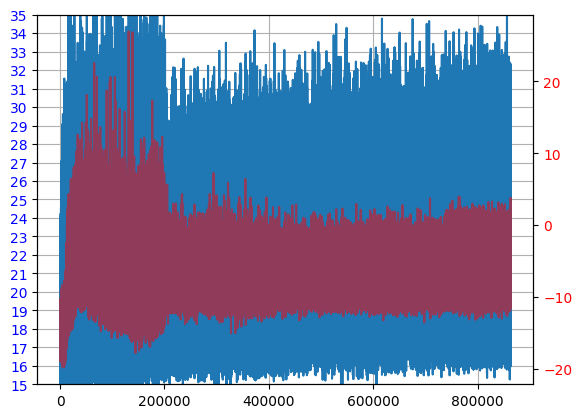

In [8]:
display(HTML(mb.main_bar.progress))
display(HTML(pb.progress))
fig, ax1 = plt.subplots()
ax1.plot(-10*np.array(losses)+6.02)
ax1.set_yticks(range(15,36))
ax1.set_ylim([15,35])
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(-10*np.array(rate_losses), color='red', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='red')
plt.show()

In [9]:
torch.save({
    'config': config,
    'state_dict': model.state_dict(),
}, '../../hf/autocodec/med3d_f8c8.pth')

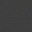

Compressed size: 1.10 KB
Compression ratio: 238.75x
Dimension reduction: 64.00x
PSNR: 20.72 dB


interactive(children=(IntSlider(value=31, description='slice_idx', max=63), Output()), _dom_classes=('widget-i…

In [19]:
from IPython.display import display, clear_output
from ipywidgets import interact

model.eval()
sample = dataset_valid[0]
x = pil_to_grid3d(sample['image']).unsqueeze(0).unsqueeze(0).to(device).to(torch.float) / 127.5 - 1.0
orig_dim = x.numel()

with torch.no_grad():
    z = model.encode(x)
    latent = model.quantize.compand(z).round()
latent = einops.rearrange(latent, 'b c d h w -> b (c d) h w').cpu()

webp = latent_to_pil(latent, n_bits=8, C=4)
display(webp[0])
buff = io.BytesIO()
webp[0].save(buff, format='WEBP', lossless=True)
size_bytes = len(buff.getbuffer())

print(f"Compressed size: {size_bytes / 1e3:.2f} KB")
print(f"Compression ratio: {orig_dim / size_bytes:.2f}x")
print(f"Dimension reduction: {orig_dim / latent.numel():.2f}x")

latent_decoded = pil_to_latent(webp, N=64, n_bits=8, C=4)
latent_decoded = einops.rearrange(latent_decoded, 'b (c d) h w -> b c d h w', d=8).to(device)

with torch.no_grad():
    x_hat = model.decode(latent_decoded).clamp(-1, 1)

mse = torch.nn.functional.mse_loss(x, x_hat)
PSNR = -10 * mse.log10().item() + 6.02

print(f"PSNR: {PSNR:.2f} dB")

original_volume = x[0,0].cpu().numpy()
reconstructed_volume = x_hat[0,0].cpu().numpy()

def show_slices(slice_idx):
    clear_output(wait=True)
    orig_slice = to_pil_image(original_volume[slice_idx]/2+0.5).resize((256,256), resample=PIL.Image.Resampling.LANCZOS)
    recon_slice = to_pil_image(reconstructed_volume[slice_idx]/2+0.5).resize((256,256), resample=PIL.Image.Resampling.LANCZOS)
    display(orig_slice)
    display(recon_slice)

interact(show_slices, slice_idx=(0, original_volume.shape[0]-1, 1));

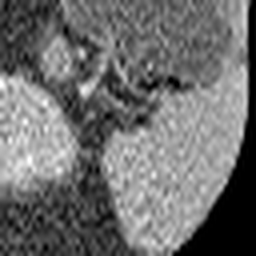

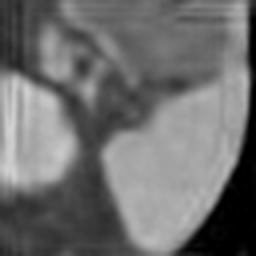

In [20]:
display(to_pil_image(original_volume[31]/2+0.5).resize((256,256), resample=PIL.Image.Resampling.LANCZOS))
display(to_pil_image(reconstructed_volume[31]/2+0.5).resize((256,256), resample=PIL.Image.Resampling.LANCZOS))

bpc: 2.90982891099194, cr: 175.95536220906638


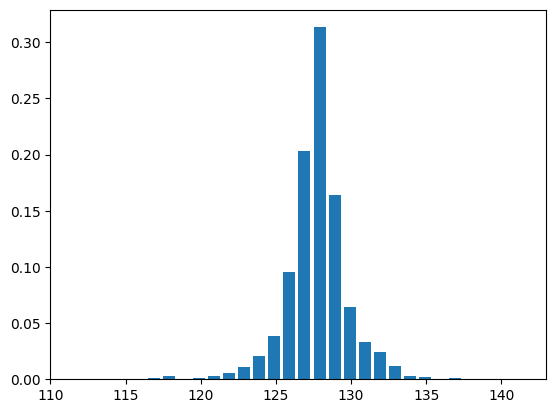

In [21]:
from torch.distributions import Categorical
x_int8 = torch.tensor(np.array(webp[0]))
h = plt.hist(x_int8.flatten(),range=(-0.5,255.5),bins=256,width=0.8,density=True)
bpc = np.log2(np.exp(1))*Categorical(torch.tensor(h[0])).entropy()
plt.xlim([110,143])
print(f"bpc: {bpc.item()}, cr: {orig_dim/latent.numel()*(8/bpc.item())}")